###### Домашнее задание к лекции "Основы веб-скрапинга"
Обязательная часть

Вам необходимо написать функцию, которая будет основана на поиске по сайту habr.com. Функция в качестве параметра должна принимать список запросов для поиска (например, ['python', 'анализ данных']) и на основе материалов, попавших в результаты поиска по каждому запросу, возвращать датафрейм вида:

<дата> - <заголовок> - <ссылка на материал>

В рамках задания предполагается работа только с одной (первой) страницей результатов поисковой выдачи для каждого запроса. Материалы в датафрейме не должны дублироваться, если они попадали в результаты поиска для нескольких запросов из списка.
Дополнительная часть (необязательная)

Функция из обязательной части задания должна быть расширена следующим образом:

    кроме списка ключевых слов для поиска необходимо объявить параметр с количеством страниц поисковой выдачи. Т.е. при передаче в функцию аргумента 4 необходимо получить материалы с первых 4 страниц результатов;
    в датафрейме должны быть столбцы с полным текстом найденных материалов и количеством лайков:

<дата> - <заголовок> - <ссылка на материал> - <текст материала> - <количество лайков>



In [66]:
#----- Окончательный вариант-------------

import pandas as pd
import requests
import time
from datetime import datetime
from dateutil import parser
from bs4 import BeautifulSoup

# Функция преобразования ISO 8601 строки в дату
def covert_to_date (date_time_str):
    # Можно распознать парсером отметку даты и сразу её вернуть
    return parser.parse(date_time_str).date()

# Функция поиска текста и числа лайков
def request_text_and_likes(url_txt):
    
    req = requests.get(url_txt).text
    time.sleep(0.1) # задержка на возможный повторный запрос
    soup_text = BeautifulSoup(req)
    # Пробуем класс форматироваия версии 1:
    # 'article-formatted-body article-formatted-body article-formatted-body_version-1'
    text_ = soup_text.find('div', 
                       class_='article-formatted-body article-formatted-body article-formatted-body_version-1' 
                           )
    form_version = 1
    
    if text_ == None:# Ничего не найдено. Нужент формат версии 2:
        text_ = soup_text.find('div', 
                       class_='article-formatted-body article-formatted-body article-formatted-body_version-2' 
                               ) 
# В выдаче по дате ссылка на 33 странице запроса "python для анализа данных" на одном из прогонов
# запрос: https://habr.com/ru/search/page33/?q=python для анализа данных&target_type=posts&order=date страница выдачи: 33
# новость https://www.habr.com/ru/company/JetBrains-education/news/t/647151/
# осущетвляет редирект на  https://habr.com/ru/company/JetBrains-education/blog/
# пустую страницу компании "JetBrains"
# чтобы это обойти пришлось усложнить код...
        
        if text_ == None: # Опять не сработало??? Значит ссылка не рабочая. Выбросить   
            print (f'В поисковой выдаче ссылка {url_txt} не адресует к конкретной информации на сайте.')
            return []
        else: # сработало на новом формате который 2
            form_version = 2
            # определим лайки
            likes_count = likes_counter(soup_text)
            print(f'Получен текст по ссылке: {url_txt}. Формат версии шаблона: {form_version}.') 
            print(f'Поставлено пользователями лайков(+)/дизлайков(-): {likes_count}.')
            return [text_.text, likes_count]
    else:# сработало сразу на формате 1, чего суетиться..
        likes_count = likes_counter(soup_text)
        print(f'Получен текст по ссылке: {url_txt}. Формат версии шаблона: {form_version}.') 
        print(f'Поставлено пользователями лайков(+)/дизлайков(-): {likes_count}.')
        return [text_.text, likes_count] 
 
# Функция определения количества  лайков
def likes_counter(soup):
   # Ищем количество лайков 
    cl_likes_positiv = "tm-votes-meter__value tm-votes-meter__value tm-votes-meter__value_positive "  
    cl_likes_positiv += "tm-votes-meter__value_appearance-article tm-votes-meter__value_rating"
   # Или дизлайков     
    cl_likes_negotiv = "tm-votes-meter__value tm-votes-meter__value tm-votes-meter__value_negative"
    cl_likes_negotiv += " tm-votes-meter__value_appearance-article tm-votes-meter__value_rating"   
    
    likes_count = 0 # обнуление - нет ни лайков, ни дизлайков
    likes_ = soup.find('span', class_= cl_likes_positiv)
    
    if likes_ != None:
        likes_count = int(likes_.text)
    else:  # а вдруг нет лайков??
        likes_ = soup.find('span', class_= cl_likes_negotiv) # тогда считаем дизлайки
        if likes_!= None: 
            likes_count = int(likes_.text)
    return likes_count

# Функция возврата статей по запросу
def get_habr_articles_list(request_lst=[], order='relevance', page_start=1, page_finish=1):
 
    habr_articles = pd.DataFrame()
    
    # Обернём всё в цикл по списку запросов 
    for request in request_lst:
        
        for page in range (page_start, page_finish+1):
            # https://habr.com/ru/search/page1/?q=python&target_type=posts&order=relevance
            url = 'https://habr.com/ru/search/page'+str(page)+'/?q=' + str(request) + '&target_type=posts&order=' +  order
            
            req = requests.get(url)
            time.sleep(0.1)
             # Проверить на успех:
            if req.status_code != 200: # что-то пошло не так, например кончились страницы
                break # выход из цикла
            
            soup = BeautifulSoup(req.text)
            print ('Запрос:', url, 'страница выдачи:', page)
            # функцей find_all  находим контейнеры всех публикаций, возвращаем список
            articles = soup.find_all('div', class_='tm-article-snippet tm-article-snippet')
            for el in articles:
            # Выделить дату и время в виде строки ISO даты и времени
                el_time = el.find('span', class_='tm-article-snippet__datetime-published')
                # Извлечь дату из объекта datetime
                data_ = covert_to_date(el_time.find('time').get('datetime'))
                # Выделить ссылку на статью
                el_ref =  el.find('a', class_='tm-article-snippet__title-link')
                # Выделить заголовок
                title_ = el_ref.text
                # Скомпоновать полную ссылку
                link = 'https://www.habr.com' + el_ref.get('href')
                # Получить текст поста, новости, записи или новости из блога 
                # компании по ссылке c количеством лайков в виде списка
                text_likes_lst = request_text_and_likes(link)
                if text_likes_lst: # если есть реальные данные
                # Добавить новую строку в датафрейм    
                    row = {'Дата':  data_, 
                           'Заголовок': title_, 
                           'Ссылка': link, 
                           'Текст': text_likes_lst[0], # собсвенно текст
                           'Лайки': text_likes_lst[1]  # лайки/дизлайки
                          }
                    habr_articles = pd.concat([habr_articles, pd.DataFrame([row])]) 
                  
    # Получить уникальные строки на основе столбца ссылок, поскольку в нем содержатся уникальные значения:
    habr_articles = habr_articles.drop_duplicates (subset=['Ссылка'])
    return habr_articles.reset_index(drop=True)
     
    
# Есть три варианта сортировки:
# по релевантоности - relevance (параметр по умолчанию)
# по времени - date 
# по рейтингу - rating
'''
search_list = ['анализ данных', 
               'python', 
               'python для анализа данных',
               'python в аналитике больших данных', 
               'Половой вопрос — 2'
              ]
'''
#search_list = ['Половой вопрос — 2'] # прекрасный тест на дизлайки
#search_list = [] # для краш-теста, который функция уже проходит

search_list = ['python', 
               'python для анализа данных',
               'python в аналитике больших данных', 
               ]

# Есть три варианта сортировки:
# по релевантности - relevance (параметр по умолчанию)
# по времени - date 
# по рейтингу - rating
sort_type = 'relevance'

# Стартовая страница для записи поиcковой 
# выдачи в датафрейм ( а вдруг нужно не начало выдачи?). По умолчанию - 1. 
start_page = 1

# Конечная страница выдачи. По умолчанию - 1. 
finish_page = 5

df_articles = get_habr_articles_list(search_list, sort_type, start_page, finish_page)

print('\n\n')
df_articles.info()

print('\n\nНайдено уникальных', len(df_articles), 
      ' значений по ', len(search_list), 
      ' запросам на', finish_page-start_page+1, 
      'страницах')
print ('\nВсего обработано значений:', 20*len(search_list)*(finish_page-start_page+1),'\n')

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", 6)
pd.set_option("display.width", 1000)
pd.set_option("display.colheader_justify", "center")
pd.set_option("display.precision", 2)
if not df_articles.empty:
    display(df_articles.sort_index(ascending = True)) # по возрастанию индекса, т.е. по выдаче в запросе


Запрос: https://habr.com/ru/search/page1/?q=python&target_type=posts&order=relevance страница выдачи: 1
Получен текст по ссылке: https://www.habr.com/ru/company/southbridge/news/t/595093/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 9.
Получен текст по ссылке: https://www.habr.com/ru/company/southbridge/news/t/646825/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 10.
Получен текст по ссылке: https://www.habr.com/ru/news/t/498364/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 19.
Получен текст по ссылке: https://www.habr.com/ru/company/raiffeisenbank/news/t/566370/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 3.
Получен текст по ссылке: https://www.habr.com/ru/company/southbridge/news/t/645485/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 10.
Получен текст по ссылке: https://www.habr.com/ru/news/t/531402/. Формат версии шаблона: 2.

Получен текст по ссылке: https://www.habr.com/ru/post/269411/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 11.
Получен текст по ссылке: https://www.habr.com/ru/company/vk/blog/337364/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 54.
Получен текст по ссылке: https://www.habr.com/ru/company/ods/blog/348260/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 39.
Получен текст по ссылке: https://www.habr.com/ru/post/415513/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 5.
Получен текст по ссылке: https://www.habr.com/ru/company/oleg-bunin/blog/418449/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 45.
Получен текст по ссылке: https://www.habr.com/ru/company/ruvds/blog/418823/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 51.
Получен текст по ссылке: https://www.habr.com/ru/company/microsoft/blog/423067/. Формат

Получен текст по ссылке: https://www.habr.com/ru/company/sbercloud/news/t/584084/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 8.
Получен текст по ссылке: https://www.habr.com/ru/company/sibur_official/news/t/593027/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 4.
Получен текст по ссылке: https://www.habr.com/ru/post/500952/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 18.
Получен текст по ссылке: https://www.habr.com/ru/post/246941/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 14.
Получен текст по ссылке: https://www.habr.com/ru/post/491326/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 12.
Получен текст по ссылке: https://www.habr.com/ru/company/skillfactory/blog/560146/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 8.
Получен текст по ссылке: https://www.habr.com/ru/post/693402/. Формат версии ша

Получен текст по ссылке: https://www.habr.com/ru/company/yandex/blog/457354/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 38.
Получен текст по ссылке: https://www.habr.com/ru/post/669980/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 0.
Запрос: https://habr.com/ru/search/page4/?q=python для анализа данных&target_type=posts&order=relevance страница выдачи: 4
Получен текст по ссылке: https://www.habr.com/ru/company/dsec/blog/685920/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 26.
Получен текст по ссылке: https://www.habr.com/ru/company/beeline/blog/274921/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): -1.
Получен текст по ссылке: https://www.habr.com/ru/post/270895/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 29.
Получен текст по ссылке: https://www.habr.com/ru/post/196560/. Формат версии шаблона: 1.
Поставлено пользователями лайк

Получен текст по ссылке: https://www.habr.com/ru/company/geekfactor/blog/689094/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 1.
Получен текст по ссылке: https://www.habr.com/ru/post/701794/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 9.
Получен текст по ссылке: https://www.habr.com/ru/company/newprolab/blog/349968/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 8.
Получен текст по ссылке: https://www.habr.com/ru/company/newprolab/blog/326762/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 4.
Получен текст по ссылке: https://www.habr.com/ru/company/ozontech/blog/562266/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 6.
Получен текст по ссылке: https://www.habr.com/ru/company/bigdataplatform/blog/673098/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 0.
Получен текст по ссылке: https://www.habr.com/ru/com

Получен текст по ссылке: https://www.habr.com/ru/company/skillfactory/blog/584810/. Формат версии шаблона: 2.
Поставлено пользователями лайков(+)/дизлайков(-): 13.
Получен текст по ссылке: https://www.habr.com/ru/company/it_people/blog/332870/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 7.
Получен текст по ссылке: https://www.habr.com/ru/company/skillbox/blog/443412/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): -15.
Получен текст по ссылке: https://www.habr.com/ru/company/lamoda/blog/518620/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 23.
Получен текст по ссылке: https://www.habr.com/ru/company/T1Holding/blog/324124/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 23.
Получен текст по ссылке: https://www.habr.com/ru/company/newprolab/blog/340582/. Формат версии шаблона: 1.
Поставлено пользователями лайков(+)/дизлайков(-): 7.
Получен текст по ссылке: https://www

,Дата,Заголовок,Ссылка,Текст,Лайки
0,2021-12-13,Жаждущим автоматизации: открытый урок «ChatOps...,https://www.habr.com/ru/company/southbridge/ne...,21 декабря Слёрм проведёт открытый урок «ChatO...,9
1,2022-01-20,Курс «Python для инженеров». Старт 3 потока 31...,https://www.habr.com/ru/company/southbridge/ne...,"Курс нацелен дать максимальную пользу, поэтому...",10
2,2020-04-21,"Вышел Python 2.7.18, последний релиз ветки Pyt...",https://www.habr.com/ru/news/t/498364/,"\r\n20 апреля 2020 года, спустя почти десять л...",19
3,2021-07-06,Python Community Meetup 8/07: видео и материал...,https://www.habr.com/ru/company/raiffeisenbank...,"Первый открытый онлайн-митап сообщества, для к...",3
4,2022-01-13,Открытый урок «Пишем Custom Prometheus Exporte...,https://www.habr.com/ru/company/southbridge/ne...,19 января Слёрм проведёт открытый урок «Пишем ...,10
5,2020-12-04,Python как компилируемый статически типизирова...,https://www.habr.com/ru/news/t/531402/,По данным широко известного в узких кругах Tio...,16
6,2022-03-08,Вышел мартовский релиз расширения Python для V...,https://www.habr.com/ru/news/t/654707/,Вышел выпуск расширения Python для Visual Stud...,0
7,2020-03-03,В начале этого года Python сместил Java и стал...,https://www.habr.com/ru/company/itsumma/news/t...,"Согласно отчету RedMonk за январь 2020 года, P...",31
8,2022-08-19,Осталась неделя до старта 4 потока Python для ...,https://www.habr.com/ru/company/southbridge/ne...,29 августа в последний раз в этом году запусти...,5
9,2020-06-03,Вышла версия 0.0.2 snakeware — дистрибутива Li...,https://www.habr.com/ru/news/t/505096/,\n\r\n31 мая 2020 года разработчик Джош Мур (J...,19


###### Ошибки выдачи уже несуществующих материалов  поисковым движком Хабр

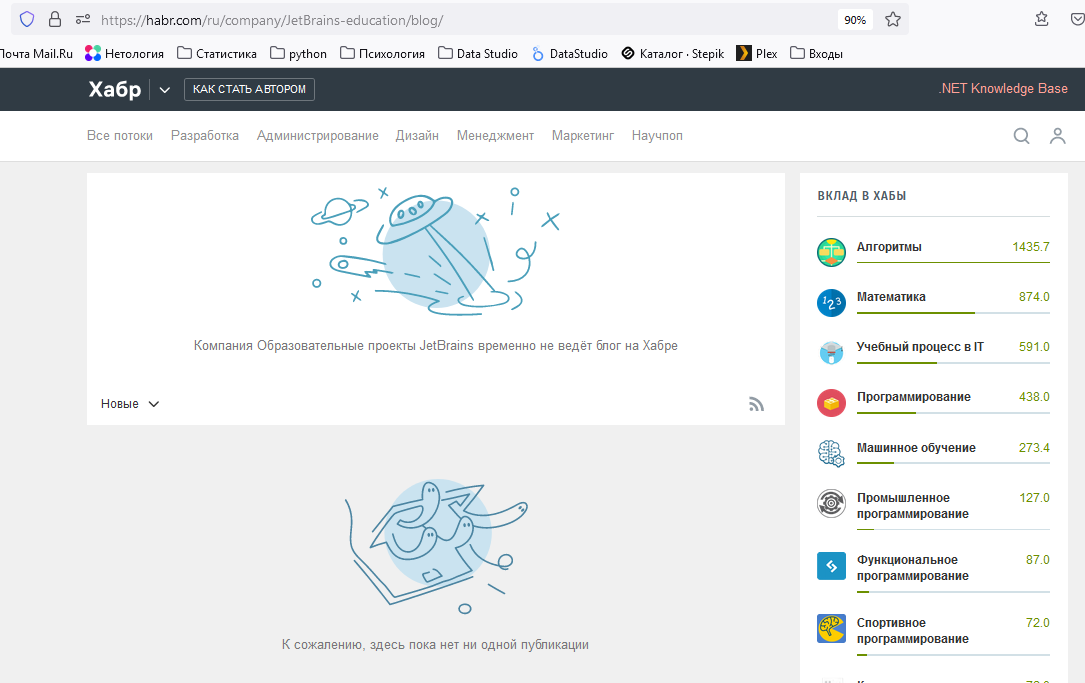

In [ ]:
# В выдаче по дате ссылка на 33 странице запроса "python для анализа данных" одного из прогонов
# Запрос: https://habr.com/ru/search/page33/?q=python для анализа данных&target_type=posts&order=date страница выдачи: 33
# новость https://www.habr.com/ru/company/JetBrains-education/news/t/647151/
# осущетвляет автоматический редирект на  
# https://habr.com/ru/company/JetBrains-education/blog/ -пустую страница компании
# "JetBrains":
'''
Ещё такая же ссылка поймана уже написанным обработчиком ошибки:
Запрос: https://habr.com/ru/search/page1/?q=python&target_type=posts&order=relevance страница выдачи: 1
В поисковой выдаче ссылка https://www.habr.com/ru/company/epam_systems/news/t/589555/ 
    не адресует к конкретной информации на сайте.
'''

link_empty = 'https://www.habr.com/ru/company/JetBrains-education/news/t/647151/'    
req = requests.get(link_empty).text
soup_req = BeautifulSoup(req)
print(soup_req.prettify())
    

###### Примеры на посмотреть данные

In [22]:
# Записпть наскарпленное непосильным трудом Хабра на диск в CSV
df_articles.to_csv (r'habr_articles.csv', index= False )

In [73]:
# Записать наскарпленное непосильным трудом Хабра на диск  в формате Excel:
df_articles.to_excel (r'habr_articles.xlsx', index= False )

In [67]:
# Самый популярный пост из найденного:
df_articles[df_articles['Лайки'] == df_articles['Лайки'].max()]
# Согласен. Сам читал.

,Дата,Заголовок,Ссылка,Текст,Лайки
101,2015-11-26,Найди коррупционера. Анализ данных чиновников ...,https://www.habr.com/ru/post/271773/,"Как определить чиновников, наиболее подозрител...",147


In [68]:
# Самый непопулярный пост:
df_articles[df_articles['Лайки'] == df_articles['Лайки'].min()]


,Дата,Заголовок,Ссылка,Текст,Лайки
180,2017-06-09,"Набор на курс Python: почему мы думаем, что Py...",https://www.habr.com/ru/company/otus/blog/330606/,Пару дней назад мы открыли набор на один из са...,-20


In [69]:
# Сколько и каких постов оставили всех равнодушными:
df_articles[df_articles['Лайки'] == 0]

,Дата,Заголовок,Ссылка,Текст,Лайки
6,2022-03-08,Вышел мартовский релиз расширения Python для V...,https://www.habr.com/ru/news/t/654707/,Вышел выпуск расширения Python для Visual Stud...,0
38,2022-04-18,Онлайн-митап от руководителя практики Python U...,https://www.habr.com/ru/company/usetech/news/t...,"В конце марта Мстислав Казаков, руководитель п...",0
126,2022-04-20,Формирование однородных групп для сплит-тестир...,https://www.habr.com/ru/post/661657/,Всем привет! Если перед вами стоит задача пров...,0
131,2021-11-16,Диаграмма воронки в Python,https://www.habr.com/ru/company/otus/blog/589593/,Диаграммы воронки зачастую используются для пр...,0
137,2020-12-07,Thank you points: сетевой анализ социальных св...,https://www.habr.com/ru/company/dataart/blog/5...,\n\r\nСвятослав Зборовский из BI-команды DataA...,0
156,2022-06-07,Визуализируем данные из xml в виде социальной ...,https://www.habr.com/ru/post/669980/,Если у Вас есть данные о связях людей в XML фо...,0
203,2022-06-24,"Лучше, чем специалист по данным: инженер-анали...",https://www.habr.com/ru/company/bigdataplatfor...,"Не так давно нам попался материал BBC, в котор...",0
213,2021-12-18,Пастух больших данных: как мы используем Azure...,https://www.habr.com/ru/post/596479/,Многие в ходе проектов сталкиваются с проблемо...,0
215,2021-02-16,Обзор современных инструментов дата-аналитика,https://www.habr.com/ru/post/542718/,"\n\r\nСразу уточню, что видов аналитиков очень...",0
250,2021-05-17,DBT: новый способ трансформации данных в The T...,https://www.habr.com/ru/post/557736/,В заключительной статье о DBT хочу поделиться ...,0


In [70]:
# Какие посты имеют положительные отзывы:
df_articles[df_articles['Лайки'] > 0].sort_values('Лайки', ascending = False) # по убыванию


,Дата,Заголовок,Ссылка,Текст,Лайки
101,2015-11-26,Найди коррупционера. Анализ данных чиновников ...,https://www.habr.com/ru/post/271773/,"Как определить чиновников, наиболее подозрител...",147
41,2013-12-18,Python на Хабре,https://www.habr.com/ru/post/205944/,"Некоторое время назад, в силу определенных при...",142
40,2012-07-09,Мысли о Python 3,https://www.habr.com/ru/post/147281/,Предлагаю вашему вниманю пересказ замечательно...,108
160,2013-10-07,Введение в анализ сложности алгоритмов (часть 1),https://www.habr.com/ru/post/196560/,От переводчика: данный текст даётся с незначит...,90
49,2014-08-28,"Python, каким бы я хотел его видеть",https://www.habr.com/ru/company/vk/blog/234747/,"Всем известно, что мне не нравится третья верс...",77
90,2013-01-27,Использование Python в многопоточном приложени...,https://www.habr.com/ru/post/167261/,Все более или менее знающие Python разработчик...,68
163,2017-05-15,"О том, как в Instagram отключили сборщик мусор...",https://www.habr.com/ru/company/wunderfund/blo...,"Отключив сборщик мусора Python (GC), который о...",66
68,2020-04-29,Практическое руководство по разработке бэкенд-...,https://www.habr.com/ru/company/yandex/blog/49...,"Привет, меня зовут Александр Васин, я бэкенд-р...",66
59,2019-06-03,Указатели в Python: в чём суть?,https://www.habr.com/ru/company/vk/blog/454324/,\r\nЕсли вы когда-нибудь работали с такими низ...,65
45,2013-02-03,Объединяя C++ и Python. Тонкости Boost.Python....,https://www.habr.com/ru/post/168083/,Boost.Python во всех отношениях замечательная ...,64


In [71]:
# Какие посты имеют отрицательные отзывы:
df_articles[df_articles['Лайки'] < 0].sort_values('Лайки', ascending = True) # по возрастанию


,Дата,Заголовок,Ссылка,Текст,Лайки
180,2017-06-09,"Набор на курс Python: почему мы думаем, что Py...",https://www.habr.com/ru/company/otus/blog/330606/,Пару дней назад мы открыли набор на один из са...,-20
135,2019-05-23,Анализ частоты появления цифр в хеше MD5,https://www.habr.com/ru/post/453094/,"Все мы знаем, как выглядит хеш, но задавались ...",-18
244,2019-03-12,Почему программисты продолжают использовать мн...,https://www.habr.com/ru/company/skillbox/blog/...,\n\nОт переводчика: эта статья — попытка автор...,-15
176,2014-12-10,Память и числа в Python,https://www.habr.com/ru/post/245491/,"Hi, All. \n\r\nРанее я работал с C-подобными я...",-13
257,2020-06-30,"8 трюков в Python, используемых опытными прогр...",https://www.habr.com/ru/company/skillfactory/b...,"\n\r\nВот восемь изящных приемов Python, котор...",-7
83,2022-09-03,Управление несколькими версиями Python под упр...,https://www.habr.com/ru/post/686186/,Одно из моих первых разочарований при разработ...,-5
65,2020-01-20,Node.js VS Python: Which is Better?,https://www.habr.com/ru/post/484634/,\n\r\nIf you are landing on this page you migh...,-3
233,2021-07-22,Платформы анализа данных: что они умеют и как ...,https://www.habr.com/ru/company/factory5/blog/...,Рынок ИТ- продуктов переполнен предложениями п...,-2
237,2021-07-16,Большая подборка телеграмм-каналов для аналитиков,https://www.habr.com/ru/post/567582/,Работа аналитика требует постоянного пополнени...,-2
146,2021-07-02,Гибридное использование RDBMS и NoSQL подходов...,https://www.habr.com/ru/post/565782/,Эксперимент по секвенированию транскриптома (R...,-1


In [72]:
# Доля  положительных+никаких (True) и отрицательных (False) отзывов :
df_articles.groupby(df_articles['Лайки'] >= 0).size() / len(df_articles)

Лайки
False    0.04
True     0.96
dtype: float64